In [99]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('semeion', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [100]:
X, y = mnist["data"], mnist["target"]
X.shape

(1593, 256)

In [101]:
y.shape

(1593,)

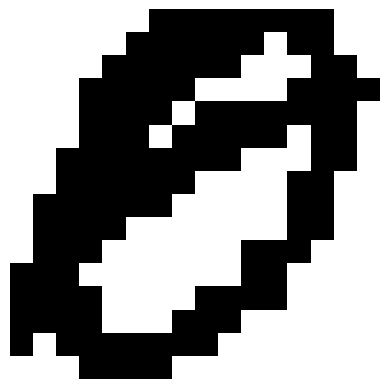

In [102]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(16, 16)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [103]:
y[0]

'1'

In [104]:
import numpy as np

y = y.astype(np.uint8)

In [105]:
def plot_digit(data):
    image = data.reshape(16, 16)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

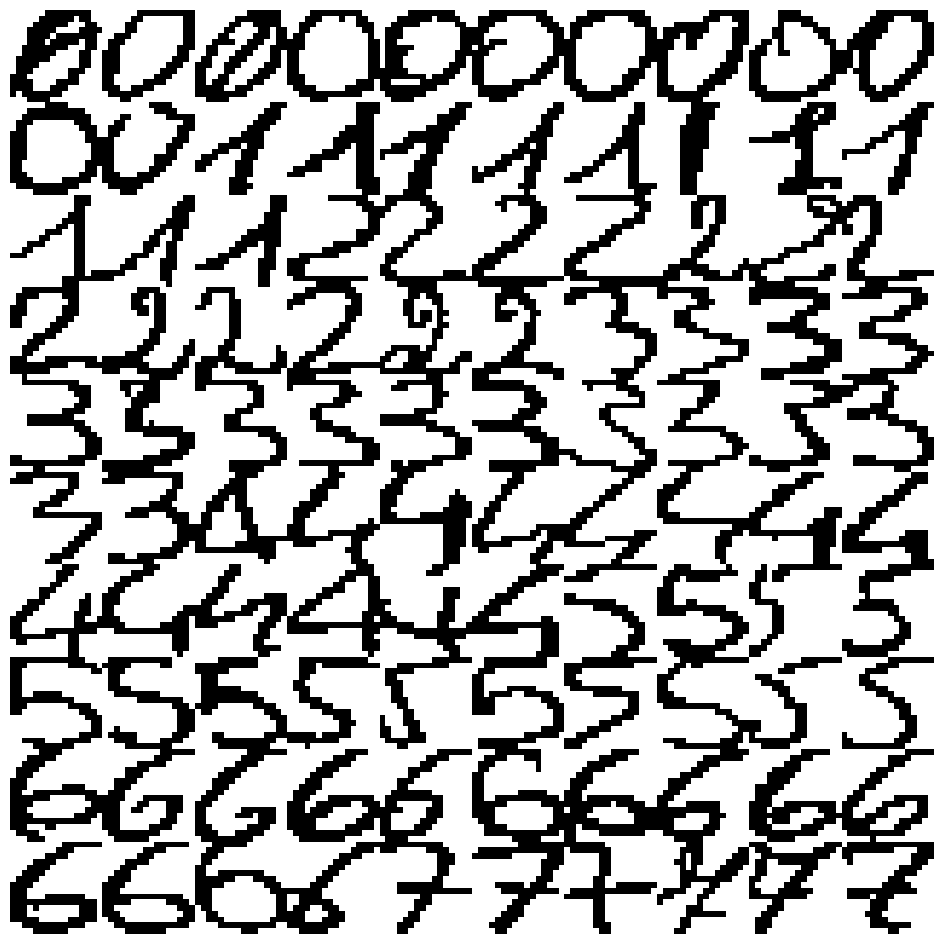

In [106]:
def plot_digits(instances, images_per_row=10, **options):
    size = 16
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)

    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(12,12))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [107]:
X_train, X_test, y_train, y_test = X[:1000], X[1000:], y[:1000], y[1000:]

### Training a Binary Classifier

In [108]:
y_train_1 = (y_train == 1)
y_test_1 = (y_test == 1)

In [109]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=13)
sgd_clf.fit(X_train, y_train_1)

SGDClassifier(random_state=13)

In [110]:
sgd_clf.predict([some_digit])

array([ True])

### Measuring Accuracy Using Cross-Validation

In [112]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_1):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_1[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_1[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9880239520958084
0.9819819819819819
0.996996996996997


In [113]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_1, cv=3, scoring="accuracy")

array([0.98502994, 0.98798799, 0.996997  ])

In [114]:
from sklearn.base import BaseEstimator

class Never1Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [115]:
never_1_clf = Never1Classifier()
cross_val_score(never_1_clf, X_train, y_train_1, cv=3, scoring="accuracy")

array([0.89221557, 0.87087087, 0.91591592])

### Confusion Matrix

In [116]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_1, cv=3)

In [117]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_1, y_train_pred)

array([[890,   3],
       [  7, 100]], dtype=int64)

In [118]:
y_train_perfect_predictions = y_train_1
confusion_matrix(y_train_1, y_train_perfect_predictions)

array([[893,   0],
       [  0, 107]], dtype=int64)

In [119]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_1, y_train_pred)

0.970873786407767

In [120]:
recall_score(y_train_1, y_train_pred)

0.9345794392523364

In [121]:
from sklearn.metrics import f1_score

f1_score(y_train_1, y_train_pred)

0.9523809523809522

### Precision/Recall Trade-off

In [122]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([33.8617087])

In [123]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [124]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [125]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_1, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_1, y_scores)

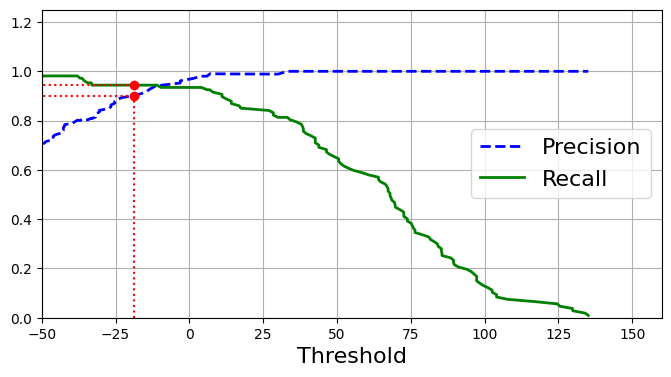

In [126]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50, 160, 0, 1.25])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                               
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                
plt.plot([-150, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-150, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                            
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
                                         
plt.show()

In [127]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [128]:
precision_score(y_train_1, y_train_pred_90)

0.9017857142857143

In [129]:
recall_score(y_train_1, y_train_pred_90)

0.9439252336448598

### The ROC Curve

In [130]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_1, y_scores)

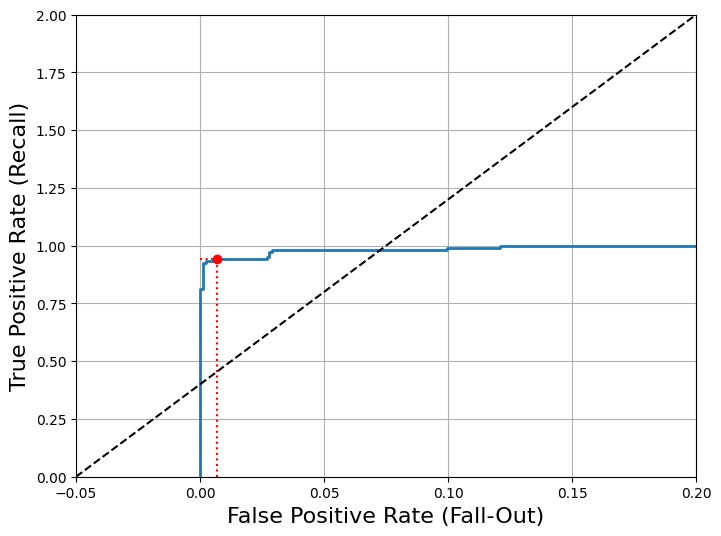

In [131]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([-0.05, 0.2], [0, 2], 'k--')
    plt.axis([-0.05, 0.2, 0, 2])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
                                   
plt.show()

In [132]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_1, y_scores)

0.9966823999748826

In [133]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_1, cv=3, method="predict_proba")
y_probas_forest

array([[0.79, 0.21],
       [0.06, 0.94],
       [0.54, 0.46],
       ...,
       [0.97, 0.03],
       [1.  , 0.  ],
       [0.99, 0.01]])

In [134]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_1,y_scores_forest)

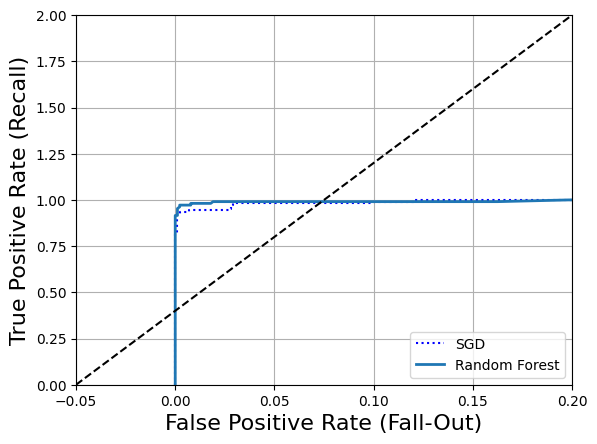

In [135]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [136]:
roc_auc_score(y_train_1, y_scores_forest)

0.9979906018775313

### Multiclass Classification

In [137]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([1], dtype=uint8)

In [139]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 9.29574279,  7.23588938, -0.27258937,  4.80252615,  2.75056843,
         2.77227674,  2.75831798,  5.90401279,  0.75479814,  8.28950577]])

In [140]:
np.argmax(some_digit_scores)

0

In [141]:
svm_clf.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [142]:
svm_clf.classes_[0]

1

In [143]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([1], dtype=uint8)

In [144]:
len(ovr_clf.estimators_)

10

In [145]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([1], dtype=uint8)

In [146]:
sgd_clf.decision_function([some_digit])

array([[  18.992183  ,  -15.79518262, -152.03051629,  -84.0693947 ,
         -68.92578102,  -96.60366612, -134.60046962, -111.72904474,
         -86.8759102 ,  -17.63936142]])

In [147]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9011976 , 0.85585586, 0.89189189])

In [148]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90419162, 0.88288288, 0.87687688])

### Error Analysis

In [149]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[104,   0,   0,   0,   0,   1,   0,   0,   0,   2],
       [  2,  73,   2,   0,   8,   1,   1,   0,   3,   3],
       [  0,   1,  94,   5,   1,   3,   0,   0,   1,   0],
       [  0,   1,   3, 111,   0,   1,   0,   1,   0,   1],
       [  0,   6,   1,   1, 104,   0,   4,   0,   1,   0],
       [  2,   1,   4,   0,   0,  98,   2,   0,   1,   1],
       [  0,   2,   1,   3,   2,   1,  98,   1,   1,   1],
       [  2,   0,   2,   1,   0,   0,   3,  68,   0,   3],
       [  0,   1,   3,   0,   0,   3,   0,   1,  71,   0],
       [  1,   4,   1,   7,   1,   0,   0,   2,   0,  67]], dtype=int64)

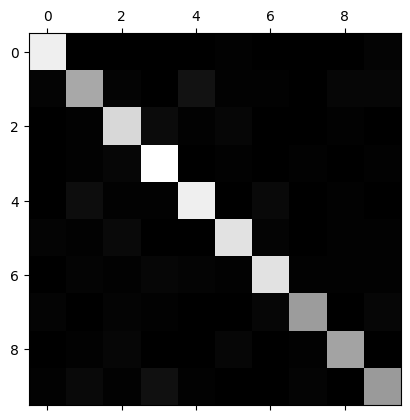

In [150]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

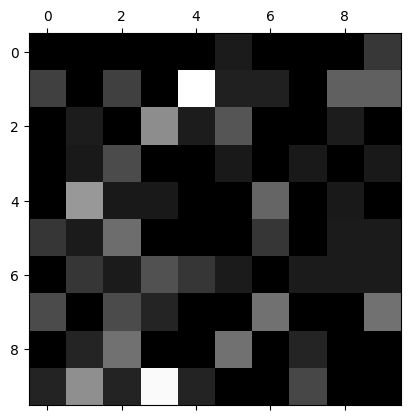

In [151]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

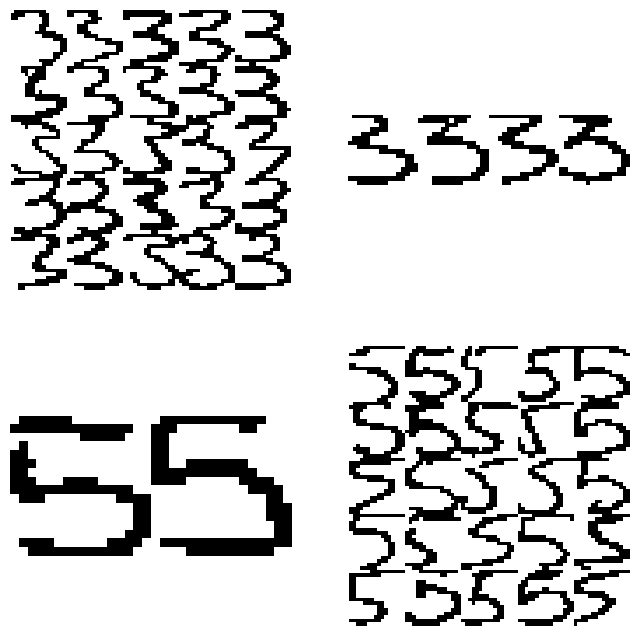

In [152]:
cl_a, cl_b = 5, 7
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

### Multilabel Classification

In [153]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [154]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [155]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.921218161683278

### Multioutput Classification

In [156]:
noise = np.random.randint(0, 2, (len(X_train), 256))
X_train_mod = X_train + noise
noise = np.random.randint(0, 2, (len(X_test), 256))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

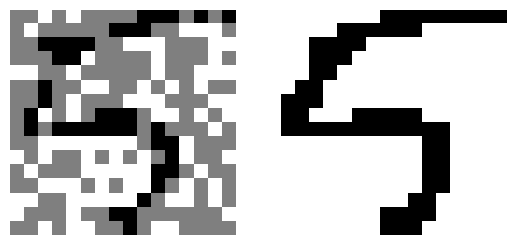

In [157]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

plt.show()

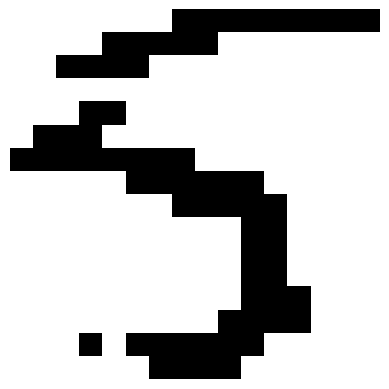

In [158]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)